# DC Capital Bikeshare demand forecast
*How would weather and day affect bikeshare demand?*

* [UCI dataset (2011-2012)](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
* [About Capital Bikeshare](https://www.capitalbikeshare.com/press-kit)

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

## Outline

* [Read Data](#read)
* [Data Summary](#data check)
* [Exploratory Data Analysis](#eda)
* [Feature Creation and Preprocessing](#preprocess)
* [Split data into test and train](#split)
* [Model and Score](#model) 
* [Predicition](#predict)
* [Reference](#reference)

In [193]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

### <a id="read">Read Data</a>

In [214]:
path = "UCI"

def readin():
    """
    read in files into pd df
    """
    readin = pd.read_csv(path,filename)
    return readin

day = pd.read_csv(path+"/day.csv")
hour = pd.read_csv(path+"/hour.csv")

In [215]:
print("days:",day.columns)
print("hours:",hour.columns)

days: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
hours: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'dayofmonth', 'train'],
      dtype='object')


In [196]:
day.shape
hour.shape #use hour data because more rows available

(17379, 19)

In [197]:
hour["yr"].value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [198]:
sum(hour["casual"])/sum(hour["cnt"])
sum(hour["registered"])/sum(hour["cnt"])

0.81169831617354748

In [199]:
hour.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,Train
0,1,1/1/11,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,1
1,2,1/1/11,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,1


### <a id="data check">Data Summary</a>

### Variables:
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

### Data check:
1. coerce datatypes of "season, holiday, workingday, and weather" to be category
2. no missing values

In [200]:
hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dayofmonth      int64
Train           int64
dtype: object

In [201]:
categoryVariableList = ["hr","weekday","mnth","season","weathersit","holiday","workingday"]
for var in categoryVariableList:
    hour[var] = hour[var].astype("category")

In [202]:
hour.isnull().values.any() #no missing values

False

In [203]:
hour.describe()

,instant,yr,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,Train
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,15.683411,0.626388
std,5017.0295,0.500008,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,8.789373,0.483776
min,1.0000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,4345.5000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,8.000000,0.000000
50%,8690.0000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,16.000000,1.000000
75%,13034.5000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,23.000000,1.000000
max,17379.0000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,31.000000,1.000000


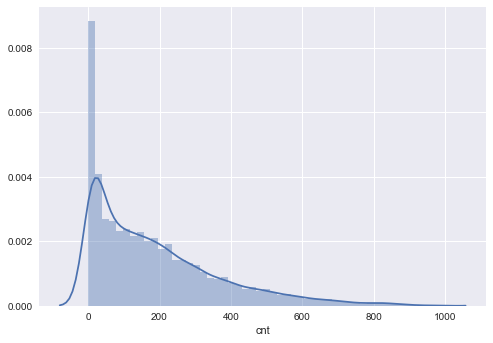

In [204]:
#check the distribution of count (response variable)
sn.distplot(hour["cnt"])
plt.show() #right skewed, not surprised given its a count variable, apply log transform later and investigate on the cnt = 1

In [205]:
lowcnt = hour[hour["cnt"] < 5]
lowcnt.shape
lowcnt["mnth"].value_counts() #month 1,2,3 and 12 have low demands

1     147
2     131
3     124
12     92
4      73
11     58
5      49
10     37
9      30
6      28
8      26
7      26
Name: mnth, dtype: int64

### <a id="eda">Exploratory Data Analysis</a>

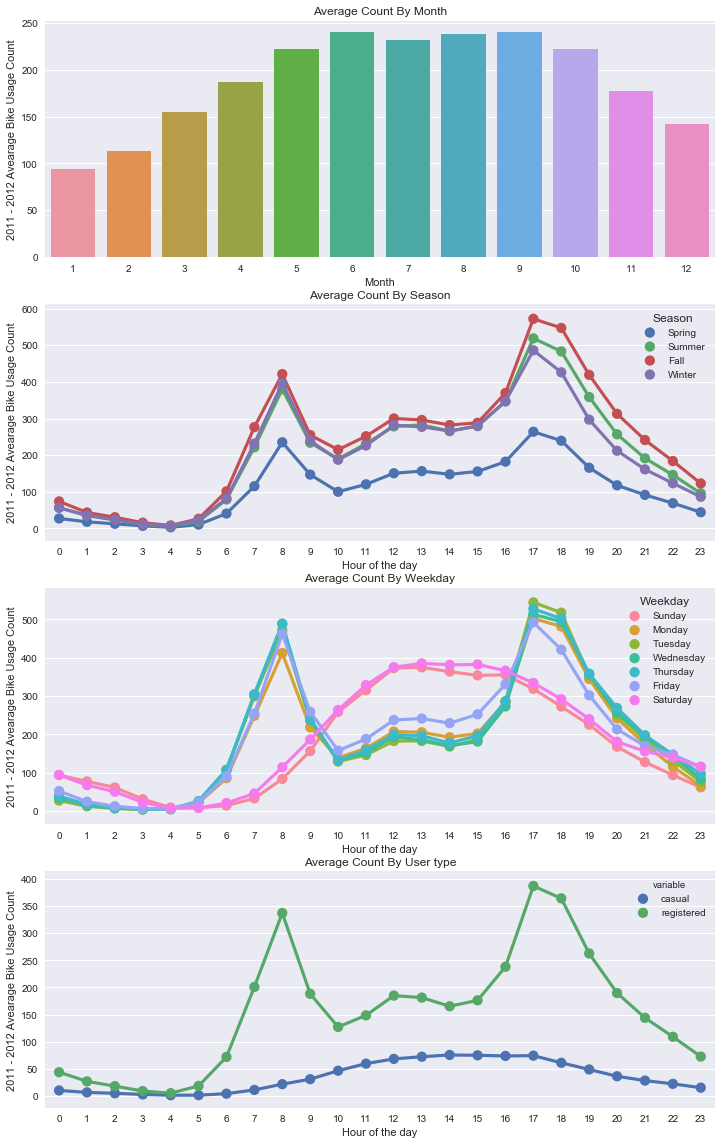

In [206]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)

monthAggregated = pd.DataFrame(hour.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="mnth",y="cnt", ax=ax1)
ax1.set(xlabel='Month', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Month")

sAggregated = pd.DataFrame(hour.groupby(["hr", "season"])["cnt"].mean()).reset_index()
sn.pointplot(x=sAggregated["hr"], y=sAggregated["cnt"],hue=sAggregated["season"], data=sAggregated, join=True,ax=ax2)
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ["Spring","Summer","Fall","Winter"], title='Season')
ax2.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Season")

#People rent bikes in the morning and evening to commute during weekdays, and rent bikes for daytime rides on weekends
wkdAgg = pd.DataFrame(hour.groupby(["hr", "weekday"])["cnt"].mean()).reset_index()
sn.pointplot(x=wkdAgg["hr"], y=wkdAgg["cnt"],hue=wkdAgg["weekday"], data=wkdAgg, join=True,ax=ax3)
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ["Sunday","Monday","Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], title='Weekday')
ax3.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Weekday")

#Registerered users versus casual users bike behaviors - more casual users rent it during day times
hourTransformed = pd.melt(hour[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAgg = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAgg["hr"], y=hourAgg["value"], hue=hourAgg["variable"], data=hourAgg, join=True, ax=ax4)
ax4.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By User type")

plt.show()

**Correlation analysis**
* correlation plot between "count" and ["temp","atemp","hum","windspeed"].
* Observations:
    - atemp and temp are highly correlated, only keep 1 for model building
    - humidity negatively impacts demand
    - windspeed slightly impact demand

In [207]:
corrmat = hour[["temp", "atemp", "hum", "windspeed", "cnt"]].corr()
corrmat

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.093234
cnt,0.404772,0.400929,-0.322911,0.093234,1.000000


**Outliers check**
* There appears to be outliers during workingday (remove later before model building)

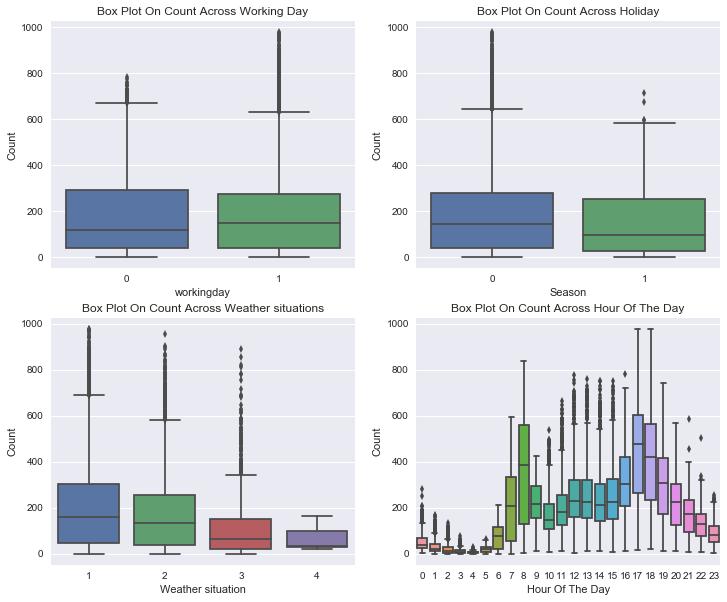

In [208]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=hour, y="cnt", x="workingday", orient="v", ax=axes[0][0]) #more outliers during workingday
sn.boxplot(data=hour, y="cnt", x="holiday", orient="v", ax=axes[0][1]) #more outliers during non-holiday
sn.boxplot(data=hour, y="cnt", x="weathersit", orient="v", ax=axes[1][0])
sn.boxplot(data=hour, y="cnt", x="hr", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count Across Working Day")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Holiday")
axes[1][0].set(xlabel='Weather situation', ylabel='Count',title="Box Plot On Count Across Weather situations")
axes[1][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
plt.show()

### <a id="preprocess">Feature Creation and Preprocessing</a>

In [209]:
hour.columns
#drop instant (row identifier)
#hour = hour.drop(['instant'],axis=1)

#coerce feature types
hour.columns
dropFeatures = ["casual","atemp", "registered", "dteday"]

### <a id="split">Split data into test and train</a>

In [229]:
#the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.

alldata = hour.drop(dropFeatures, axis=1)
datatrain = alldata[alldata["train"]==1]
datatest = alldata[alldata["train"]!=1]

datatrain.shape
datatest.shape

#Next step: remove outliers in train

(6493, 15)

### <a id="model">Model and Score</a>

**RMSLE Scorer **

<img src="score.png">

In [242]:
def rmsle(yhat,y,convertExp=True):
    if convertExp:
        y=np.exp(y),
        yhat=np.exp(yhat)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in yhat]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    diff = (log1-log2)**2
    return np.sqrt(np.mean(diff))

** Linear Regression Model **

In [230]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [251]:
# Initialize linear regression model
lModel = LinearRegression()

# Train the model
yLabels = datatrain["cnt"]
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = datatrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= datatrain)
print ("RMSLE Value For Linear Regression training data: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression training data:  0.667694507854


In [252]:
#Make prediction on test data
yLabels = datatest["cnt"]
yLabelsLog = np.log1p(yLabels)
# Make predictions
predstest = lModel.predict(X= datatest)
print ("RMSLE Value For Linear Regression using test data: ",rmsle(np.exp(yLabelsLog),np.exp(predstest),False))

RMSLE Value For Linear Regression using test data:  0.671783469726


In [241]:
lModel.coef_

array([ -2.43411130e-03,   2.28481338e-02,   2.12767747e+01,
         1.78325400e+00,   6.08897007e-02,  -2.28013483e-02,
         6.97719016e-03,  -8.47366888e-02,   1.98625217e-02,
         3.62868401e-01,  -4.14073003e-01,   5.89037796e-02,
         5.15126345e-03,   5.91973735e-02,   0.00000000e+00])

#add predictor significance
https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

#see if I can cut down input feature vars/fewer user input into website
#provide 2016 pop stations

** Random Forest **